# Recurrent Neural Network Forecasting Model

In [1]:
import tseriesRoutines as routines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import ceil, sqrt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta

Using TensorFlow backend.


In [2]:
# RESULT REPRODUCIBILITY
########################
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(42)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(42)

In [3]:
def genData(mongoid, conn, cursor, impute=True, freq='daily'):
    '''
    Generate a timeseries dataframe for timeseries modelling.
    mongoid: str. string of mongodb id.
    conn: sqlite3 connection.
    cursor: sqlite3 cursor.
    impute:
    freq:
    actualrevcount:
    '''
    initial = routines.sqlToDf(conn, cursor)
    allproduct = initial.selectReview3(mongoid, impute=impute)
    product = routines.tsSalesRateSentiment(allproduct, freq=freq)
    return product
    # product = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=True, 
    #   freq='daily')


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data.copy()
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg = agg.dropna()
    return agg

In [26]:
def splitDataNN(df, n_in=1, n_out=1, scale=True, percent=0.2):
    '''
    df: pandas dataframe. 3 columns (sales, rating, ovsentiment) with date as index
    n_in:
    n_out:
    scale:
    percent:
    X_train, y_train, X_test, y_test, dftrain = splitDataNN(product, n_in=1, 
        n_out=1, scale=True, percent=0.2)
    '''
    dftrain = series_to_supervised(df, n_in=n_in, n_out=n_out)
    # specific to this case
    dftrain = dftrain.drop(dftrain.columns[[4, 5]], axis=1)
    dftrain = dftrain[['var1(t-1)', 'var1(t)']]
    values = dftrain.values

    if scale:
        scaler = MinMaxScaler()
        values = scaler.fit_transform(values)
    else:
        pass

    # training data
    X, y = values[:, :-1], values[:, -1]
    # train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=percent, 
            shuffle=False, random_state=42)
    # reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    return X_train, y_train, X_test, y_test, dftrain, scaler

In [6]:
# computing the common-sense baseline MAE
def evaluate_naive_method(val_steps, val_gen):
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [8]:
def flatModel(xtrain, ytrain, xtest, ytest, epochs, batch_size, units=50, shuffle=False, 
        metrics=['accuracy'], loss='mae', plot=True, lr=0.001, accplot=False):
    '''
    xtrain:
    ytrain:
    epochs:
    batch_size:
    units:
    shuffle:
    metrics:
    loss:
    plot:
    flatmodel = flatModel(X_train, y_train, epochs=80, batch_size=64)
    '''
    # 1 - densely connected model
    #############################
    model = Sequential()
    model.add(layers.Flatten(input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=RMSprop(lr=lr), loss=loss, metrics=metrics)
    history = model.fit(xtrain, ytrain, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_data=(xtest, ytest),
                        verbose=0, shuffle=False)
    # save the output
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(loss) + 1)

    # plot
    if plot and accplot:
        # loss plot
        plt.figure(1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        # accuracy plot
        plt.figure(2)
        plt.plot(epochs, acc, label='Training acc')
        plt.plot(epochs, val_acc, label='Validation acc')
        plt.title('Training and validation Accuracy')
        plt.legend()
        plt.show()
        # print results
        print('loss: {0}'.format(np.mean(loss)))
        print('val_loss: {0}'.format(np.mean(val_loss)))
        print('acc: {0}'.format(np.mean(acc)))
        print('val_acc: {0}'.format(np.mean(val_acc)))
    elif plot:
        # loss plot
        plt.figure(1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
        # print results
        print('loss: {0}'.format(np.mean(loss)))
        print('val_loss: {0}'.format(np.mean(val_loss)))
    else:
        pass

    plt.clf()
    # return model
    return history

def gruDropModel(xtrain, ytrain, xtest, ytest, epochs, batch_size, units, drop, recdrop, 
        shuffle=False, metrics=['accuracy'], loss='mae', plot=True, lr=0.001, accplot=False):
    '''
    xtrain:
    ytrain:
    epochs:
    batch_size:
    units:
    shuffle:
    metrics:
    loss:
    plot:
    grudropmodel = gruDropModel(X_train, y_train, epochs=1000, batch_size=64, units=256, 
        drop=0.2, recdrop=0.2)
    '''
    # 3 - GRU-based model with dropout
    ##################################
    model = Sequential()
    model.add(layers.GRU(units, 
        dropout=drop,
        recurrent_dropout=recdrop,
        input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(layers.Dense(1))
    model.compile(optimizer=RMSprop(lr=lr), loss=loss, metrics=metrics)
    history = model.fit(xtrain, ytrain, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_data=(xtest, ytest),
                        verbose=0, shuffle=False)
    # save the output
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(loss) + 1)

    # plot
    if plot and accplot:
        # loss plot
        plt.figure(1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        # accuracy plot
        plt.figure(2)
        plt.plot(epochs, acc, label='Training acc')
        plt.plot(epochs, val_acc, label='Validation acc')
        plt.title('Training and validation Accuracy')
        plt.legend()
        plt.show()
        # print results
        print('loss: {0}'.format(np.mean(loss)))
        print('val_loss: {0}'.format(np.mean(val_loss)))
        print('acc: {0}'.format(np.mean(acc)))
        print('val_acc: {0}'.format(np.mean(val_acc)))
    elif plot:
        # loss plot
        plt.figure(1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
        # print results
        print('loss: {0}'.format(np.mean(loss)))
        print('val_loss: {0}'.format(np.mean(val_loss)))
    else:
        pass

    plt.clf()
    # return model
    return history

def lstmModel(xtrain, ytrain, xtest, ytest, epochs, batch_size, units, drop, recdrop, 
        shuffle=False, metrics=['accuracy'], loss='mae', plot=True, lr=0.001, accplot=False):
    '''
    xtrain:
    ytrain:
    epochs:
    batch_size:
    units:
    shuffle:
    metrics:
    loss:
    plot:
    lstmmodel = lstmModel(X_train, y_train, epochs=500, batch_size=64, units=256, 
        drop=0.2, recdrop=0.2)
    '''
    # 4 - LSTM-based model
    ######################
    model = Sequential()
    model.add(layers.LSTM(units, dropout=drop, recurrent_dropout=recdrop,
        input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(layers.Dense(1))
    model.compile(optimizer=RMSprop(lr=lr), loss=loss, metrics=metrics)
    history = model.fit(xtrain, ytrain, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_data=(xtest, ytest),
                        verbose=0, shuffle=False)
    # save the output
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(loss) + 1)

    # plot
    if plot and accplot:
        # loss plot
        plt.figure(1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        # accuracy plot
        plt.figure(2)
        plt.plot(epochs, acc, label='Training acc')
        plt.plot(epochs, val_acc, label='Validation acc')
        plt.title('Training and validation Accuracy')
        plt.legend()
        plt.show()
        # print results
        print('loss: {0}'.format(np.mean(loss)))
        print('val_loss: {0}'.format(np.mean(val_loss)))
        print('acc: {0}'.format(np.mean(acc)))
        print('val_acc: {0}'.format(np.mean(val_acc)))
    elif plot:
        # loss plot
        plt.figure(1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
        # print results
        print('loss: {0}'.format(np.mean(loss)))
        print('val_loss: {0}'.format(np.mean(val_loss)))
    else:
        pass

    plt.clf()
    # return model
    return history

In [9]:
def evalForecast(model, X, y, inverse=False, scaler=None):
    '''
    Evaluate time series forecasting model
    '''
    if inverse and scaler:
        # make prediction
        ypred = model.model.predict(X)
        # reshape X
        X = X.reshape((X.shape[0], X.shape[2]))
        # invert scaling predicted data
        inv_ypred = np.concatenate((X[:, :], ypred), axis=1)
        inv_ypred = scaler.inverse_transform(inv_ypred)
        inv_ypred = inv_ypred[:, -1]
        # invert scaling for actual data
        y = y.reshape((len(y), 1))
        inv_y = np.concatenate((X[:, :], y), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:, -1]
        # RMSE
        rmse = np.sqrt(mean_squared_error(y_pred=inv_ypred, y_true=inv_y))
        # MAE
        mae = mean_absolute_error(y_pred=inv_ypred, y_true=inv_y)
    else:
        # make prediction
        ypred = model.model.predict(X)
        # RMSE
        rmse = np.sqrt(mean_squared_error(y_pred=ypred, y_true=y))
        # MAE
        mae = mean_absolute_error(y_pred=ypred, y_true=y)

    print('Validasi RMSE: {0:.5f}'.format(rmse))
    print('Validasi MAE: {0:.5f}'.format(mae))

In [10]:
# make connection to sqlite db
conn = sqlite3.connect('product.db')
c = conn.cursor()

# enable foreign keys
c.execute("PRAGMA foreign_keys = ON")
conn.commit()

<br>pilihan:
>     2 data di database product.db dgn review > 900:
>         5aa2ad7735d6d34b0032a795
>         5aa39533ae1f941be7165ecd
>     cluster 3
>         5a93e8768cbad97881597597
>         or 
>         5a95d7ae35d6d33d3fea56ff
>     cluster 1
>         5aa2c35e35d6d34b0032a796
>     cluster 2 
>         5a92474635d6d32207bcd343
</br>

## <font color=blue> 1. Mongodb ID: 5aa2ad7735d6d34b0032a795 </font>

In [27]:
product = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=False, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [28]:
X_train.shape, product.shape

((383, 1, 1), (480, 3))

In [29]:
product.head()

,Sales,rating,ovsentiment
date,,,
2016-11-06,2,3.500000,0.500000
2016-11-07,1,5.000000,1.000000
2016-11-08,0,0.000000,0.000000
2016-11-09,0,0.000000,0.000000
2016-11-10,3,4.666667,0.333333


In [30]:
X_train

array([[[0.25 ]],

       [[0.125]],

       [[0.   ]],

       [[0.   ]],

       [[0.375]],

       [[0.   ]],

       [[0.   ]],

       [[0.   ]],

       [[0.125]],

       [[0.25 ]],

       [[0.   ]],

       [[0.   ]],

       [[0.375]],

       [[0.   ]],

       [[0.   ]],

       [[0.   ]],

       [[0.375]],

       [[0.   ]],

       [[0.375]],

       [[0.   ]],

       [[0.375]],

       [[0.   ]],

       [[0.125]],

       [[0.25 ]],

       [[0.25 ]],

       [[0.125]],

       [[0.   ]],

       [[0.375]],

       [[0.125]],

       [[0.25 ]],

       [[0.125]],

       [[0.375]],

       [[0.25 ]],

       [[0.375]],

       [[0.25 ]],

       [[0.   ]],

       [[0.   ]],

       [[0.25 ]],

       [[0.25 ]],

       [[0.25 ]],

       [[0.375]],

       [[0.   ]],

       [[0.   ]],

       [[0.375]],

       [[0.375]],

       [[0.375]],

       [[0.375]],

       [[0.5  ]],

       [[0.25 ]],

       [[0.   ]],

       [[0.375]],

       [[0.   ]],

       [[0.2

In [31]:
dftrain.head()

,var1(t-1),var1(t)
date,,
2016-11-07,2.0,1
2016-11-08,1.0,0
2016-11-09,0.0,0
2016-11-10,0.0,3
2016-11-11,3.0,0


In [32]:
dftrain['var1(t-1)'].sum()

918.0

### 1 - Densely Connected Model

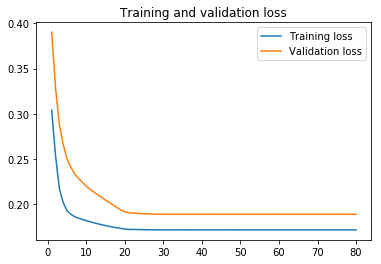

loss: 0.17661995445730713
val_loss: 0.2002532140274222


In [33]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=8, loss='mae', units=4)

In [34]:
evalForecast(flatmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 1.61892
Validasi MAE: 1.37184


In [35]:
#flatmodel.model.save('./training/forecast_nn_5aa2ad7735d6d34b0032a795_flatmodel.h5')

### 3 - GRU-based Model with Dropout

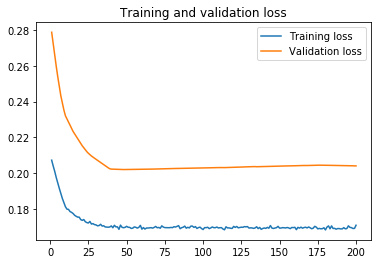

loss: 0.1714006496384234
val_loss: 0.20723850642020503


In [36]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=8, drop=0.01, recdrop=0.01, lr=0.0001)

In [37]:
evalForecast(grudropmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 1.57873
Validasi MAE: 1.35276


In [49]:
#grudropmodel.model.save('./training/forecast_nn_5aa2ad7735d6d34b0032a795_grudropmodel_uni.h5')

### 4 - LSTM-based Model

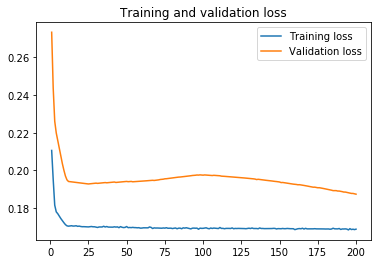

loss: 0.16988054874846736
val_loss: 0.1952346855774522


In [22]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=4, drop=0.002, recdrop=0.002)

In [23]:
evalForecast(lstmmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 1.56656
Validasi MAE: 1.34726


In [15]:
#lstmmodel.model.save('./training/forecast_nn_5aa2ad7735d6d34b0032a795_lstmmodel_uni.h5')

## <font color=blue> 2. Mongodb ID: 5aa39533ae1f941be7165ecd </font>

In [38]:
product = genData('5aa39533ae1f941be7165ecd', conn, c, impute=False, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [39]:
X_train.shape, product.shape

((463, 1, 1), (580, 3))

### 1 - Densely Connected Model

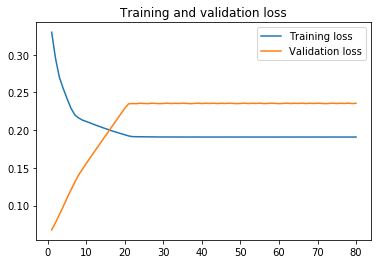

loss: 0.19943700941887002
val_loss: 0.2154142653730152


In [40]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=16, units=8)

In [41]:
evalForecast(flatmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 1.61171
Validasi MAE: 1.33735


In [34]:
#flatmodel.model.save('./training/forecast_nn_5aa39533ae1f941be7165ecd_flatmodel.h5')

### 3 - GRU-based Model with Dropout

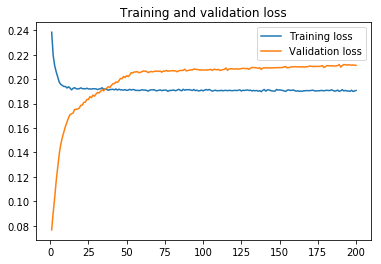

loss: 0.19170825296960625
val_loss: 0.20013749780326054


In [42]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=32, units=8, drop=0.01, recdrop=0.01, lr=0.0009)

In [43]:
evalForecast(grudropmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 1.59232
Validasi MAE: 1.32929


In [57]:
#grudropmodel.model.save('./training/forecast_nn_5aa39533ae1f941be7165ecd_grudropmodel_uni.h5')

### 4 - LSTM-based Model

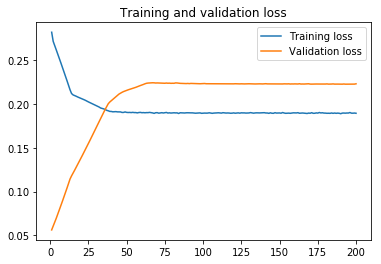

loss: 0.19500251777421837
val_loss: 0.20499777820089768


In [44]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=32, units=8, drop=0.01, recdrop=0.01, lr=0.0005)

In [45]:
evalForecast(lstmmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 1.59801
Validasi MAE: 1.32536


In [23]:
#lstmmodel.model.save('./training/forecast_nn_5aa39533ae1f941be7165ecd_lstmmodel_uni.h5')

## <font color=blue> 3. Mongodb ID: 5a93e8768cbad97881597597 </font>

In [46]:
product = genData('5a93e8768cbad97881597597', conn, c, impute=False, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [47]:
X_train.shape, product.shape

((894, 1, 1), (1119, 3))

### 1 - Densely Connected Model

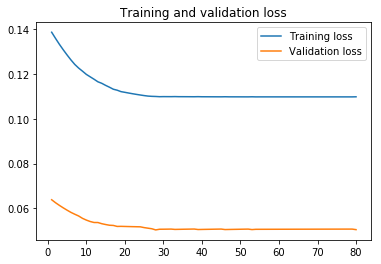

loss: 0.1127419008650469
val_loss: 0.05211519541751062


In [48]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=64, loss='mae', units=8)

In [49]:
evalForecast(flatmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 6.15889
Validasi MAE: 3.29418


In [48]:
#flatmodel.model.save('./training/forecast_nn_5a93e8768cbad97881597597_flatmodel.h5')

### 3 - GRU-based Model with Dropout

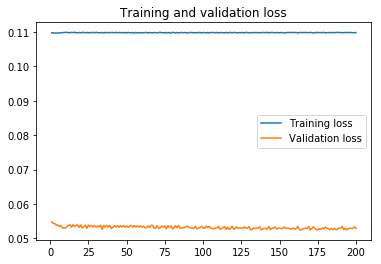

loss: 0.10981878207859626
val_loss: 0.053190346206538376


In [50]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=16, units=8, drop=0.01, recdrop=0.01, lr=0.0008)

In [51]:
evalForecast(grudropmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 6.04369
Validasi MAE: 3.31109


In [64]:
#grudropmodel.model.save('./training/forecast_nn_5a93e8768cbad97881597597_grudropmodel_uni.h5')

### 4 - LSTM-based Model

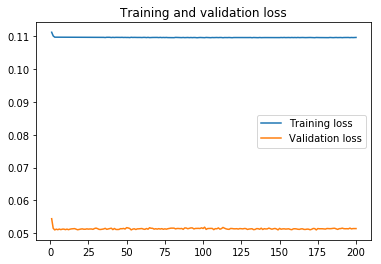

loss: 0.10967918021494384
val_loss: 0.051309744884659135


In [52]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=16, units=8, drop=0.02, recdrop=0.02, lr=0.0008)

In [53]:
evalForecast(lstmmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 6.12341
Validasi MAE: 3.30122


In [56]:
#lstmmodel.model.save('./training/forecast_nn_5a93e8768cbad97881597597_lstmmodel_uni.h5')

## <font color=blue> 5. Mongodb ID: 5aa2c35e35d6d34b0032a796 </font>

In [54]:
product = genData('5aa2c35e35d6d34b0032a796', conn, c, impute=False, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [55]:
X_train.shape, product.shape

((341, 1, 1), (428, 3))

### 1 - Densely Connected Model

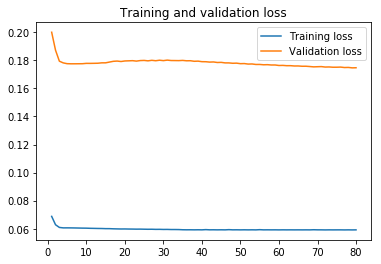

loss: 0.05968757348491529
val_loss: 0.17815691964310962


In [56]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=16, loss='mae', units=8)

In [57]:
evalForecast(flatmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 5.75954
Validasi MAE: 3.79582


In [86]:
#flatmodel.model.save('./training/forecast_nn_5aa2c35e35d6d34b0032a796_flatmodel.h5')

### 3 - GRU-based Model with Dropout

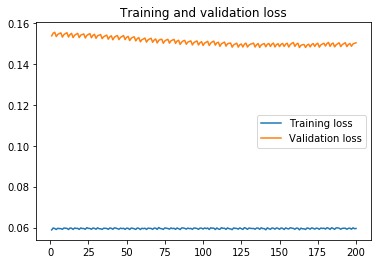

loss: 0.05951401035114005
val_loss: 0.15103310537719447


In [58]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=16, units=8, drop=0.01, recdrop=0.01, lr=0.0005)

In [59]:
evalForecast(grudropmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 5.41701
Validasi MAE: 3.81468


In [73]:
#grudropmodel.model.save('./training/forecast_nn_5aa2c35e35d6d34b0032a796_grudropmodel_uni.h5')

### 4 - LSTM-based Model

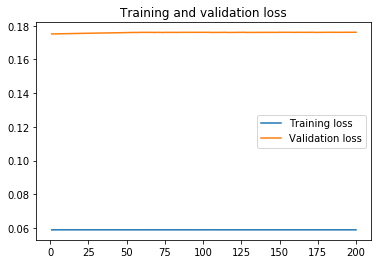

loss: 0.058869541892367906
val_loss: 0.17594517501980758


In [60]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=4, drop=0.01, recdrop=0.01, lr=0.00008)

In [61]:
evalForecast(lstmmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 5.97988
Validasi MAE: 3.77054


In [94]:
#lstmmodel.model.save('./training/forecast_nn_5aa2c35e35d6d34b0032a796_lstmmodel.h5')

## <font color=blue> 6. Mongodb ID: 5a9347b98cbad97074cb1890 </font>

In [62]:
product = genData('5a9347b98cbad97074cb1890', conn, c, impute=False, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [63]:
X_train.shape, product.shape

((252, 1, 1), (317, 3))

### 1 - Densely Connected Model

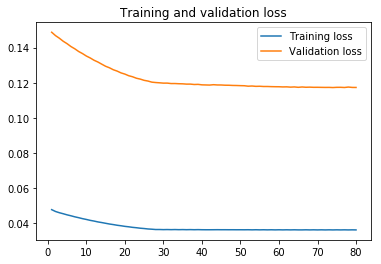

loss: 0.03781872448524819
val_loss: 0.12288619973696768


In [64]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=16, loss='mae', units=8)

In [65]:
evalForecast(flatmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 0.28178
Validasi MAE: 0.07167


In [102]:
#flatmodel.model.save('./training/forecast_nn_5a92474635d6d32207bcd343_flatmodel.h5')

### 3 - GRU-based Model with Dropout

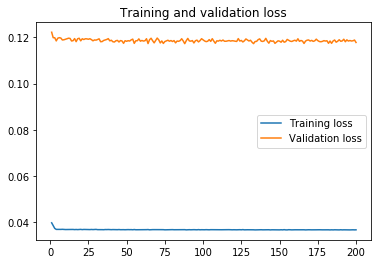

loss: 0.036681438941844204
val_loss: 0.11863809020424924


In [66]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=4, drop=0.05, recdrop=0.05, lr=0.001)

In [67]:
evalForecast(grudropmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 0.28123
Validasi MAE: 0.07332


In [81]:
#grudropmodel.model.save('./training/forecast_nn_5a9347b98cbad97074cb1890_grudropmodel_uni.h5')

### 4 - LSTM-based Model

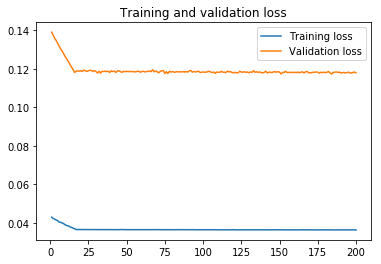

loss: 0.03673942782084695
val_loss: 0.11914959985693485


In [68]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=4, drop=0.02, recdrop=0.02, lr=0.001)

In [69]:
evalForecast(lstmmodel, X_train, y_train, inverse=True, scaler=scaler)

Validasi RMSE: 0.28126
Validasi MAE: 0.07337


In [110]:
#lstmmodel.model.save('./training/forecast_nn_5a92474635d6d32207bcd343_lstmmodel.h5')